In [1]:
from sklearn.datasets import fetch_lfw_people

from sklearn.model_selection import train_test_split
import mglearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
% matplotlib inline

## 데이터 로딩

사이킷런에서 인물들의 얼굴 이미지를 모든 데이터셋을 얻을 수 있습니다.

총 3023 개의 데이터이면 87 x 65 크기의 이미지 입니다.

모두 다른 사람의 이미지가 아니라 같은 사람의 이미지가 여러장 있습니다.

이번 실습에서는 숫자 이미지 대신 사람의 얼굴 이미지로 그 사람이 누구인지 맞추는 분류문제입니다.



In [2]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

In [3]:
people.images.shape

(3023, 87, 65)

### 인물별 샘플의 크기를 알아봅시다

0 부터 레이블이 되어 있는 자료는 bincount  라는 numpy 함수로 샘플의 출현횟수를 계산할 수 있습니다.

In [6]:
counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

총 62명의 사진이있고 각 인물마다 적어도 20장 이상의 사진이 데이터셋에 들어가 있습니다.

## 데이터 시각화

데이터가 이미지이므로 있는 그대로를 출력하겠습니다.

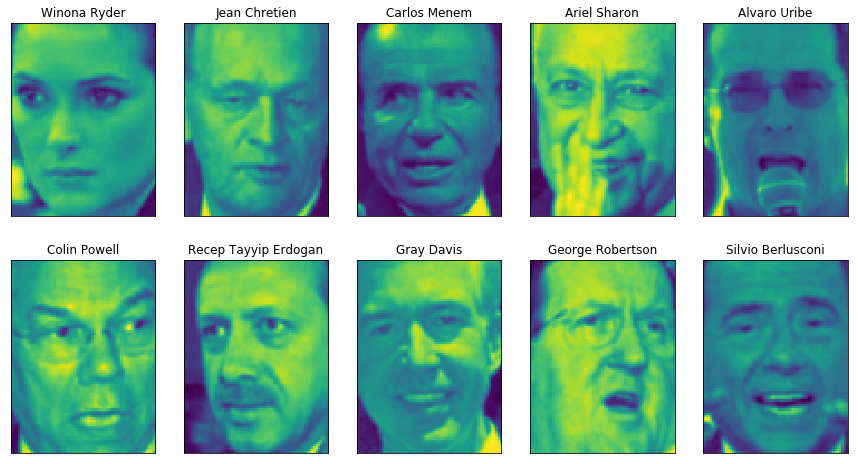

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target[:10], people.images[:10], axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

Colin Powell  이란 사람의 사진은 250개 이상이 있습니다. 사진이 적은 사람은 20개 밖에 되질 않습니다.

이상태로 훈련을 시키면 Colin Powell 과  같이 샘플이 많은 인물을 중심으로 훈련이 될 수 밖에 없습니다.

각 인물 별로 샘플 수를 최대 30 개로 제한을 하겠습니다. 

사진은 그레이스케일로 픽셀당 0부터 255까지의 숫자 정보를 가지고 있습니다.  이 큰 범위의 숫자를 255로 나눠서 0에서 1 사이의 숫자로 스케일링 하겠습니다.

In [9]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:30]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
X_people = X_people / 255.

## 데이터를 훈련용과 테스트용으로 나누기

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

## KNN 알고리즘으로 분류



In [12]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 0.21


정확도는 21% 로 62개를 분류하는 문제에서 아주 나쁜 결과는 아니지만 PCA 를 사용해서 정확도를 더 높여보겠습니다.

PCA의 화이트닝 옵션을 사용해서 주성분의 스케일이 같아지도록 조정합니다.

참고로 화이트닝을 적용하는 것은 PCA 변화 후에 StandardScaler 를 적용하는 것과 습니다.

## PCA 로 차원 축소

원래는 5천개가 넘는 피처이지만 이 중에서 100 개의 주요 성분으로 다시 분류를 해보겠습니다.

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set score: 0.31


정확도가 31%로 무려 10%나 올랐습니다.


피처는 많을 수록 좋은 것이 아닙니다.  타켓의 값과 상관있는 피쳐만 남겨두어야지 분류기의 성능이 좋아집니다.
타겟 값과 상관없는 피처가 많아지만 분류긴의 성능은 떨어집니다.

## 이번에는 SVM 으로 분류

In [18]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

print("Test set score (SVM before PCA): {:.2f}".format(clf.score(X_test, y_test)))

Test set score (SVM before PCA): 0.11


In [19]:
clf.fit(X_train_pca, y_train)

print("Test set score (SVM after PCA): {:.2f}".format(clf.score(X_test_pca, y_test)))

Test set score (SVM after PCA): 0.52


SVM 에서는 차원축소로 어마어마한 성능 향상이 있었습니다.  11% 에서 52% 로 분류 정확도가 높아졌습니다.

##  주성분 이미지 시각화

100 개가 되는 주성분 중에서 10개에 대한 이미지를 시각화해보고 어떤 특징을 주성분으로 사용했는지 생각해보겠습니다.

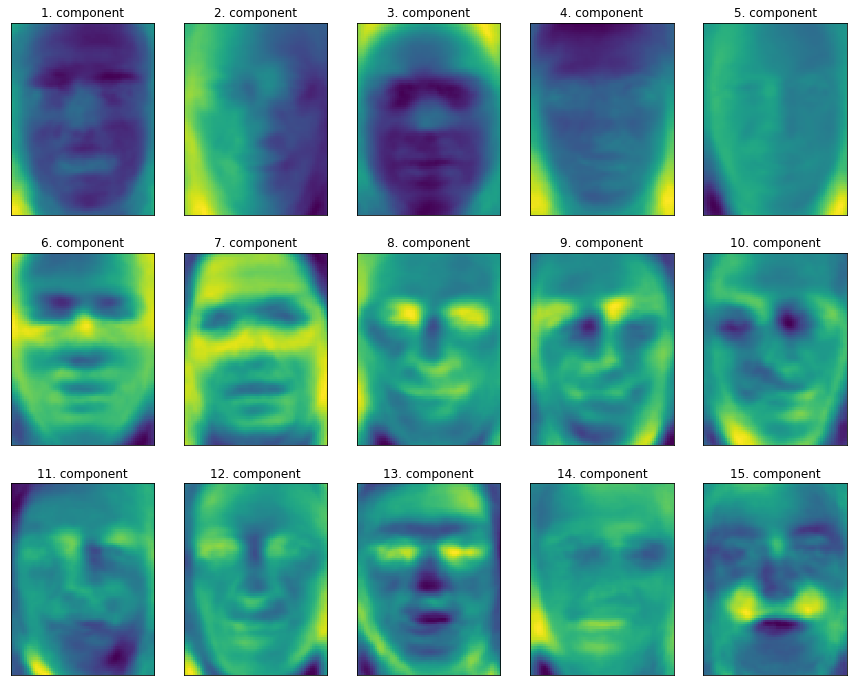

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
plt.show()

주성분이 잡아낸 얼굴 특징을 보면

첫 번째는 얼굴과 배열의 명암차이를 기록한 것 처럼 보이고

두 번째는 왼쪽과 오른쪽의 조명 차이, 일곱 번쨰는 이마와 광대뼈 쪽의 특징을 잡아낸 성분인 것 같습니다.

## 주성분으로 표현된 원본 이미지

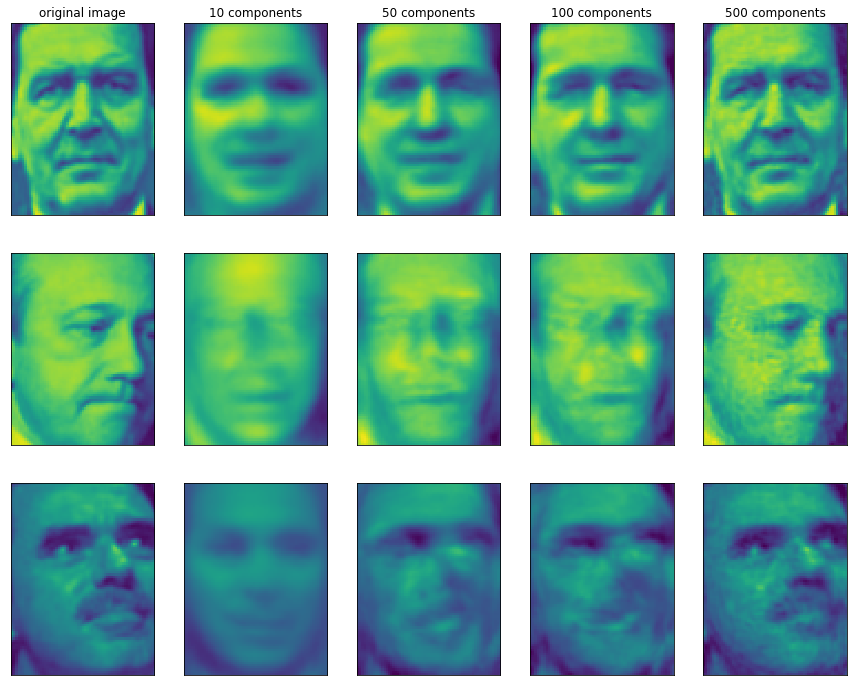

In [26]:

reduced_images = []
for n_components in [10, 50, 100, 500, 2000]:
    # build the NMF model
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    # transform the test data (afterwards has n_components many dimensions)
    X_test_pca = pca.transform(X_test)
    # back-transform the transformed test-data
    # (afterwards it's in the original space again)
    X_test_back = pca.inverse_transform(X_test_pca)
    reduced_images.append(X_test_back)


# plot the first three images in the test set:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes):
    # plot original image
    ax[0].imshow(X_test[i].reshape(image_shape),
                 vmin=0, vmax=1)
    # plot the four back-transformed images
    for a, X_test_back in zip(ax[1:], reduced_images):
        a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

# label the top row
axes[0, 0].set_title('original image')
for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500, 2000]):
    ax.set_title("%d components" % n_components)

당연한 결과이지만 이미지에 사용하는 성분이 많을 수록 사람의 눈에는 분류하기 쉬워집니다.

100 개의 피처만 사용해서 나타내는 얼굴의 윤곽으로 정확인 누구인지를 맞추기는 쉬운 일은 아니지만

머신러닝으로 50% 의 성능을 보였습니다.